# **Mobile phones or microbial mirrors - does the microbiome of a mobile phone reflect its user’s?**
## **Data analysis**

### Creating a metadata.tsv file

A Google sheet was created with columns for sample id, sample number (to link phone and hand samples), sample origin, gender, screen time and phone cleanliness. This was validated as a QIIME2 metadata file and downloaded as a tab-separated file before being copied from the local home directory to Cartesius.

### Importing the demultiplexed data as an artifact using manifest

In [9]:
%%time
!qiime tools import \
    --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-path pe-reads/manifest.tsv \
    --output-path demux \
    --input-format PairedEndFastqManifestPhred33V2

Imported pe-reads/manifest.tsv as PairedEndFastqManifestPhred33V2 to demux
CPU times: user 256 ms, sys: 67.5 ms, total: 324 ms
Wall time: 28.6 s


In [10]:
%%time
!qiime tools peek demux.qza

UUID:        2b2edfb5-967e-45e0-8190-ae466f77a74a
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt
CPU times: user 9.4 ms, sys: 7.57 ms, total: 17 ms
Wall time: 1.24 s


### Visualising the demultiplexed data

In [1]:
from qiime2 import Visualization

In [ ]:
%%time
!qiime demux summarize \
    --i-data demux.qza \
    --o-visualization demux.qzv

In [6]:
Visualization.load('demux.qzv')

<visualization: Visualization uuid: 427abdaf-03ef-4215-94b3-b321d138014b>

### End-joining the paired-end reads using VSEARCH

In [2]:
%%time
!qiime vsearch join-pairs \
    --i-demultiplexed-seqs demux.qza \
    --output-dir joined \
    --p-minovlen 50 \
    --p-maxdiffs 0 \
    --p-allowmergestagger

Saved SampleData[JoinedSequencesWithQuality] to: joined/joined_sequences.qza
CPU times: user 408 ms, sys: 110 ms, total: 517 ms
Wall time: 47.4 s


In [3]:
%%time 
!qiime demux summarize \
    --i-data joined/joined_sequences.qza \
    --o-visualization joined/joined_sequences.qzv

Saved Visualization to: joined/joined_sequences.qzv
CPU times: user 89.5 ms, sys: 42.3 ms, total: 132 ms
Wall time: 13.7 s


In [6]:
Visualization.load('joined/joined_sequences.qzv')

<visualization: Visualization uuid: b2412ef5-c9fb-4e12-917a-69a57e188918>

### Quality filtering the end-joined sequences by Q-score

In [7]:
%%time
!qiime quality-filter q-score-joined \
    --i-demux joined/joined_sequences.qza \
    --output-dir filtered

Saved SampleData[JoinedSequencesWithQuality] to: filtered/filtered_sequences.qza
Saved QualityFilterStats to: filtered/filter_stats.qza
CPU times: user 425 ms, sys: 87.4 ms, total: 513 ms
Wall time: 1min 13s


In [8]:
%%time
!qiime demux summarize \
    --i-data filtered/filtered_sequences.qza \
    --o-visualization filtered/filtered_sequences.qzv

Saved Visualization to: filtered/filtered_sequences.qzv
CPU times: user 93.6 ms, sys: 31.4 ms, total: 125 ms
Wall time: 14.1 s


In [2]:
Visualization.load('filtered/filtered_sequences.qzv')

<visualization: Visualization uuid: e112b97e-8929-4cd8-ad38-00875c71e828>

In [10]:
%%time
!qiime metadata tabulate \
    --m-input-file filtered/filter_stats.qza \
    --o-visualization filtered/filter_stats.qzv

Saved Visualization to: filtered/filter_stats.qzv
CPU times: user 49.2 ms, sys: 18.5 ms, total: 67.6 ms
Wall time: 5.7 s


In [11]:
Visualization.load('filtered/filter_stats.qzv')

<visualization: Visualization uuid: c4d2072b-32a9-4e54-87c9-341161dcfaa4>

### Picking Amplicon Sequence Variants (ASVs) using Deblur

In [12]:
%%time
!qiime deblur denoise-16S \
    --i-demultiplexed-seqs filtered/filtered_sequences.qza \
    --p-trim-length 252 \
    --output-dir deblur \
    --p-sample-stats \
    --p-jobs-to-start 24

Saved FeatureTable[Frequency] to: deblur/table.qza
Saved FeatureData[Sequence] to: deblur/representative_sequences.qza
Saved DeblurStats to: deblur/stats.qza
CPU times: user 924 ms, sys: 198 ms, total: 1.12 s
Wall time: 1min 45s


A trim length of 252 base-pairs was chosen by looking at the quality plots and sequnce length summary in the demultiplexed summary visualisation. In the 10,000 sequences subsampled from the entire sequence set, very few sequences were less than 252 base-pairs. 

In [15]:
%%time
!qiime deblur visualize-stats \
    --i-deblur-stats deblur/stats.qza \
    --o-visualization deblur/stats.qzv

Saved Visualization to: deblur/stats.qzv
CPU times: user 44.1 ms, sys: 17.9 ms, total: 62 ms
Wall time: 5.48 s


In [3]:
Visualization.load('deblur/stats.qzv')

<visualization: Visualization uuid: ac26da6f-43c1-4554-8a69-52804d1966c7>

### Constructing a Feature Table

In [14]:
%%time
!qiime feature-table summarize \
    --i-table deblur/table.qza \
    --o-visualization deblur/table.qzv \
    --m-sample-metadata-file phone_microbiome_metadata.tsv

!qiime feature-table tabulate-seqs \
    --i-data deblur/representative_sequences.qza \
    --o-visualization deblur/representative_sequences.qzv

Saved Visualization to: deblur/table.qzv
Saved Visualization to: deblur/representative_sequences.qzv
CPU times: user 113 ms, sys: 34.2 ms, total: 147 ms
Wall time: 12.6 s


In [2]:
Visualization.load('deblur/table.qzv')

<visualization: Visualization uuid: b080d506-a4b3-4cb0-afed-0e06e631799c>

In [3]:
Visualization.load('deblur/representative_sequences.qzv')

<visualization: Visualization uuid: 41cfddfe-da97-4964-9554-32021f70dcb6>

### Importing the reference dataset from the Greengenes database

The Greengenes 13_8 99% OTU data set was chosen for training the Naive Bayes classifier. The 99% OTU reference sequences and 99% OTU taxonomic classifications from the unpacked gg_13_8.otus.tar.gz file were copied to Cartesius and moved to the Greengenes directory, before being imported into artifacts.

In [20]:
!mkdir greengenes

In [1]:
%%time
!qiime tools import \
    --type 'FeatureData[Sequence]' \
    --input-path greengenes/99_otus.fasta \
    --output-path greengenes/99_otus.qza

!qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --input-format HeaderlessTSVTaxonomyFormat \
    --input-path greengenes/99_otu_taxonomy.txt \
    --output-path greengenes/ref_taxonomy.qza

Imported greengenes/99_otus.fasta as DNASequencesDirectoryFormat to greengenes/99_otus.qza
Imported greengenes/99_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to greengenes/ref_taxonomy.qza
CPU times: user 543 ms, sys: 132 ms, total: 674 ms
Wall time: 1min


### Trimming reference reads to the target amplicon (16S rRNA gene V4 region) using the 515f/806r primer pair

In [2]:
%%time
!qiime feature-classifier extract-reads \
    --i-sequences greengenes/99_otus.qza \
    --p-f-primer GTGYCAGCMGCCGCGGTAA \
    --p-r-primer GGACTACNVGGGTWTCTAAT \
    --p-min-length 100 \
    --p-max-length 400 \
    --o-reads greengenes/ref_seqs.qza

Saved FeatureData[Sequence] to: greengenes/ref_seqs.qza
CPU times: user 8.41 s, sys: 1.85 s, total: 10.3 s
Wall time: 15min 35s


### Training the Naive Bayes classifier using the trimmed reference reads

In [3]:
%%time
!qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads greengenes/ref_seqs.qza \
    --i-reference-taxonomy greengenes/ref_taxonomy.qza \
    --o-classifier greengenes/naive_bayes_classifier.qza

Saved TaxonomicClassifier to: greengenes/naive_bayes_classifier.qza
CPU times: user 2.31 s, sys: 574 ms, total: 2.89 s
Wall time: 4min 26s


### Assigning taxonomy using the Naive Bayes classifier constructed from the Greengenes database

In [17]:
!mkdir taxonomy

In [18]:
%%time
!qiime feature-classifier classify-sklearn \
    --i-classifier greengenes/naive_bayes_classifier.qza \
    --i-reads deblur/representative_sequences.qza \
    --o-classification taxonomy/classification.qza

Saved FeatureData[Taxonomy] to: taxonomy/classification.qza
CPU times: user 580 ms, sys: 114 ms, total: 694 ms
Wall time: 1min 5s


In [19]:
!qiime metadata tabulate \
    --m-input-file taxonomy/classification.qza \
    --o-visualization taxonomy/classification.qzv

Saved Visualization to: taxonomy/classification.qzv


In [4]:
Visualization.load('taxonomy/classification.qzv')

<visualization: Visualization uuid: 254640f4-c35c-4a3c-ae73-61ae8a5dbad0>

### Removing Chloroplast and Mitochondrial DNA

I noticed that some of the assigned taxonomy corresponded to 16S rRNA genes from chloroplast and mitochondrial DNA, so these sequences were removed from the deblur feature table and representative sequences for further analysis.

In [91]:
%%time
!qiime taxa filter-table \
    --i-table deblur/table.qza \
    --i-taxonomy taxonomy/classification.qza \
    --p-exclude mitochondria,chloroplast \
    --o-filtered-table deblur/no-mitochondria-no-chloroplast-table.qza

Saved FeatureTable[Frequency] to: deblur/no-mitochondria-no-chloroplast-table.qza
CPU times: user 51 ms, sys: 18.6 ms, total: 69.5 ms
Wall time: 6.16 s


In [8]:
%%time 
!qiime feature-table filter-seqs \
    --i-data deblur/representative_sequences.qza \
    --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
    --o-filtered-data deblur/no-mitochondria-no-chloroplast-repseqs.qza

Saved FeatureData[Sequence] to: deblur/no-mitochondria-no-chloroplast-repseqs.qza
CPU times: user 87.8 ms, sys: 30.1 ms, total: 118 ms
Wall time: 8.58 s


In [9]:
%%time
!qiime feature-table summarize \
    --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
    --o-visualization deblur/no-mitochondria-no-chloroplast-table.qzv \
    --m-sample-metadata-file phone_microbiome_metadata.tsv

!qiime feature-table tabulate-seqs \
    --i-data deblur/no-mitochondria-no-chloroplast-repseqs.qza \
    --o-visualization deblur/no-mitochondria-no-chloroplast-repseqs.qzv

Saved Visualization to: deblur/no-mitochondria-no-chloroplast-table.qzv
Saved Visualization to: deblur/no-mitochondria-no-chloroplast-repseqs.qzv
CPU times: user 201 ms, sys: 53.6 ms, total: 254 ms
Wall time: 18 s


In [11]:
Visualization.load('deblur/no-mitochondria-no-chloroplast-table.qzv')

<visualization: Visualization uuid: 42d55af7-9c14-4008-8cac-dbd0929a6cef>

In [14]:
Visualization.load('deblur/no-mitochondria-no-chloroplast-repseqs.qzv')

<visualization: Visualization uuid: 0a53ba9d-c8ab-419e-a057-4ef3505624e7>

### Creating a taxa bar-plot for all samples

In [92]:
%%time
!qiime taxa barplot \
    --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
    --i-taxonomy taxonomy/classification.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization taxonomy/taxa_bar_plot.qzv

Saved Visualization to: taxonomy/taxa_bar_plot.qzv
CPU times: user 56.1 ms, sys: 30 ms, total: 86.2 ms
Wall time: 7.18 s


In [93]:
Visualization.load('taxonomy/taxa_bar_plot.qzv')

<visualization: Visualization uuid: 51513fe4-bbd0-403d-aec8-8db0ad837c30>

### Creating a taxa bar plot with most abundant taxa in phone and hand samples

In [94]:
%%time
!qiime tools export \
    --input-path taxonomy/taxa_bar_plot.qzv \
    --output-path taxonomy/taxa_bar_plot

Exported taxonomy/taxa_bar_plot.qzv as Visualization to directory taxonomy/taxa_bar_plot
CPU times: user 19.2 ms, sys: 15.6 ms, total: 34.8 ms
Wall time: 2.16 s


In [6]:
import pandas as pd

In [96]:
taxal2_df = pd.read_csv('taxonomy/taxa_bar_plot/level-2.csv', index_col=0)

In [97]:
taxal2_df.sort_index(inplace=True)

In [98]:
taxal2_df.head()

,k__Bacteria;__,k__Bacteria;p__,k__Bacteria;p__Acidobacteria,k__Bacteria;p__Actinobacteria,k__Bacteria;p__Armatimonadetes,k__Bacteria;p__Bacteroidetes,k__Bacteria;p__Chloroflexi,k__Bacteria;p__Cyanobacteria,k__Bacteria;p__Firmicutes,k__Bacteria;p__Fusobacteria,...,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
index,,,,,,,,,,,,,,,,,,,,,
515rcbc272,0.0,0.0,0.0,80.0,0.0,2.0,0.0,0.0,341.0,0.0,...,P1,phone,1.0,male,NaN,male,138.0,138.0,never,never
515rcbc273,0.0,0.0,0.0,738.0,0.0,13.0,0.0,6.0,1891.0,3.0,...,P2,phone,2.0,male,NaN,male,360.0,360.0,never,never
515rcbc274,0.0,0.0,0.0,53.0,0.0,18.0,0.0,0.0,227.0,7.0,...,P3,phone,3.0,female,NaN,female,72.0,72.0,yearly,yearly
515rcbc275,0.0,0.0,0.0,153.0,0.0,4.0,0.0,0.0,201.0,0.0,...,P4,phone,4.0,female,NaN,female,210.0,210.0,never,never
515rcbc276,0.0,0.0,0.0,25.0,0.0,2.0,0.0,0.0,125.0,0.0,...,P5,phone,5.0,female,NaN,female,318.0,318.0,never,never


In [99]:
start, end = taxal2_df.columns.get_indexer(['k__Bacteria;__', 'sample'])
taxa_columns = taxal2_df.columns[start:end]
taxal2_df['all'] = taxal2_df.loc[:,taxa_columns].sum(axis=1)
taxal2_df.loc[:,taxa_columns] = taxal2_df.loc[:, taxa_columns].div(taxal2_df['all'],axis=0).mul(100,axis=0)

In [100]:
taxal2_df.drop(['sample number', 'screen time min', 'screen time min for phone samples only'], axis = 1, inplace = True)

In [101]:
taxal2_phone_df = taxal2_df[taxal2_df['sample origin'] == 'phone']

In [102]:
taxal2_phone_mean = taxal2_phone_df.mean(numeric_only=True, axis=0)

In [103]:
taxal2_phone_mean.sort_values(ascending=False).head(15)

all                               4996.379310
k__Bacteria;p__Firmicutes           55.584694
k__Bacteria;p__Proteobacteria       26.452892
k__Bacteria;p__Actinobacteria       15.434096
k__Bacteria;p__Bacteroidetes         1.821695
k__Bacteria;p__Fusobacteria          0.431528
k__Bacteria;p__Cyanobacteria         0.089277
k__Bacteria;p__Synergistetes         0.069042
k__Bacteria;p__[Thermi]              0.038499
k__Bacteria;p__Spirochaetes          0.032573
k__Bacteria;p__Verrucomicrobia       0.020566
k__Bacteria;p__Planctomycetes        0.009379
k__Bacteria;__                       0.007162
k__Bacteria;p__Chloroflexi           0.003515
k__Bacteria;p__                      0.003281
dtype: float64

In [143]:
taxal2_phone5_dict = {"Phylum": ["Firmicutes", "Proteobacteria", "Actinobacteria", "Bacteroidetes", "Fusobacteria"], "Relative abundance (%)": [55.584694, 26.452892, 15.434096, 1.821695, 0.431528]}

In [145]:
taxal2_phone5_df = pd.DataFrame(taxal2_phone5_dict)

In [146]:
taxal2_phone5_df

,Phylum,Relative abundance (%)
0,Firmicutes,55.584694
1,Proteobacteria,26.452892
2,Actinobacteria,15.434096
3,Bacteroidetes,1.821695
4,Fusobacteria,0.431528


In [147]:
taxal2_phone5_other = 100-sum(taxal2_phone5_df["Relative abundance (%)"])

In [148]:
taxal2_phone5_other_df = ({"Phylum": "Other", "Relative abundance (%)": taxal2_phone5_other})

In [155]:
taxal2_phone5_df.append(taxal2_phone10_other_df, ignore_index = True)

,Phylum,Relative abundance (%)
0,Firmicutes,55.584694
1,Proteobacteria,26.452892
2,Actinobacteria,15.434096
3,Bacteroidetes,1.821695
4,Fusobacteria,0.431528
5,Other,0.275095


In [156]:
taxal2_hand_df = taxal2_df[taxal2_df['sample origin'] == 'hand']

In [157]:
taxal2_hand_mean = taxal2_hand_df.mean(numeric_only=True, axis=0)

In [158]:
taxal2_hand_mean.sort_values(ascending=False).head(15)

all                               11321.862069
k__Bacteria;p__Proteobacteria        36.829052
k__Bacteria;p__Firmicutes            35.276389
k__Bacteria;p__Actinobacteria        24.483072
k__Bacteria;p__Bacteroidetes          2.548398
k__Bacteria;p__Fusobacteria           0.489808
k__Bacteria;p__[Thermi]               0.209385
k__Bacteria;p__                       0.056732
k__Bacteria;p__Acidobacteria          0.016790
k__Bacteria;p__Cyanobacteria          0.016728
k__Bacteria;p__Tenericutes            0.014075
k__Bacteria;p__Spirochaetes           0.013081
k__Bacteria;p__Verrucomicrobia        0.012277
k__Bacteria;p__Planctomycetes         0.009384
k__Bacteria;p__TM7                    0.006363
dtype: float64

In [159]:
taxal2_hand5_dict = {"Phylum": ["Firmicutes", "Proteobacteria", "Actinobacteria", "Bacteroidetes", "Fusobacteria"], "Relative abundance (%)": [35.276389, 36.829052, 24.483072, 2.548398, 0.489808]}

In [160]:
taxal2_hand5_df = pd.DataFrame(taxal2_hand5_dict)

In [162]:
taxal2_hand5_df

,Phylum,Relative abundance (%)
0,Firmicutes,35.276389
1,Proteobacteria,36.829052
2,Actinobacteria,24.483072
3,Bacteroidetes,2.548398
4,Fusobacteria,0.489808


In [163]:
taxal2_hand5_other = 100-sum(taxal2_hand5_df["Relative abundance (%)"])

In [164]:
taxal2_hand5_other_df = ({"Phylum": "Other", "Relative abundance (%)": taxal2_hand5_other})

In [165]:
taxal2_hand5_df.append(taxal2_hand5_other_df, ignore_index = True)

,Phylum,Relative abundance (%)
0,Firmicutes,35.276389
1,Proteobacteria,36.829052
2,Actinobacteria,24.483072
3,Bacteroidetes,2.548398
4,Fusobacteria,0.489808
5,Other,0.373281


In [7]:
taxal6_df = pd.read_csv('taxonomy/taxa_bar_plot/level-6.csv', index_col=0)

In [8]:
taxal6_df.sort_index(inplace=True)

In [9]:
taxal6_df.head()

,k__Bacteria;__;__;__;__;__,k__Bacteria;p__;c__;o__;f__;g__,k__Bacteria;p__Acidobacteria;c__[Chloracidobacteria];o__RB41;f__Ellin6075;g__,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__;g__,k__Bacteria;p__Actinobacteria;c__Acidimicrobiia;o__Acidimicrobiales;f__Microthrixaceae;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium,...,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
index,,,,,,,,,,,,,,,,,,,,,
515rcbc272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P1,phone,1.0,male,NaN,male,138.0,138.0,never,never
515rcbc273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,P2,phone,2.0,male,NaN,male,360.0,360.0,never,never
515rcbc274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,P3,phone,3.0,female,NaN,female,72.0,72.0,yearly,yearly
515rcbc275,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,...,P4,phone,4.0,female,NaN,female,210.0,210.0,never,never
515rcbc276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P5,phone,5.0,female,NaN,female,318.0,318.0,never,never


In [10]:
start, end = taxal6_df.columns.get_indexer(['k__Bacteria;__;__;__;__;__', 'sample'])
taxa_columns = taxal6_df.columns[start:end]
taxal6_df['all'] = taxal6_df.loc[:,taxa_columns].sum(axis=1)
taxal6_df.loc[:,taxa_columns] = taxal6_df.loc[:, taxa_columns].div(taxal6_df['all'],axis=0).mul(100,axis=0)

In [11]:
taxal6_df.drop(['sample number', 'screen time min', 'screen time min for phone samples only'], axis = 1, inplace = True)

In [19]:
taxal6_phone_df = taxal6_df[taxal6_df['sample origin'] == 'phone']

In [20]:
taxal6_phone_mean = taxal6_phone_df.mean(numeric_only=True, axis=0)

In [21]:
taxal6_phone_mean.sort_values(ascending=False).head(15)

all                                                                                                                4996.379310
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                         38.747550
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus                             6.631492
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium           6.399886
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter             6.119469
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium       4.346184
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__                    4.044497
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Enhydrobacter      

In [22]:
taxal6_phone10_dict = {"Genus": ["Streptococcus", "Staphylococcus", "Corynebacterium", "Acinetobacter", "Propionibacterium", "Enterobacteriaceae", "Enhydrobacter", "Lactobacillus", "Haemophilus", "Pseudomonas"], "Relative abundance (%)": [38.74755, 6.631492, 6.399886, 6.119469, 4.346184, 4.044497, 3.802505, 3.640008, 2.857268, 1.828021]}

In [23]:
taxal6_phone10_df = pd.DataFrame(taxal6_phone10_dict)

In [24]:
taxal6_phone10_df

,Genus,Relative abundance (%)
0,Streptococcus,38.747550
1,Staphylococcus,6.631492
2,Corynebacterium,6.399886
3,Acinetobacter,6.119469
4,Propionibacterium,4.346184
5,Enterobacteriaceae,4.044497
6,Enhydrobacter,3.802505
7,Lactobacillus,3.640008
8,Haemophilus,2.857268
9,Pseudomonas,1.828021


In [25]:
taxal6_phone10_other = 100-sum(taxal6_phone10_df["Relative abundance (%)"])

In [26]:
taxal6_phone10_other_df = ({"Genus": "Other", "Relative abundance (%)": taxal6_phone10_other})

In [27]:
taxal6_phone10_df.append(taxal6_phone10_other_df, ignore_index = True)

,Genus,Relative abundance (%)
0,Streptococcus,38.747550
1,Staphylococcus,6.631492
2,Corynebacterium,6.399886
3,Acinetobacter,6.119469
4,Propionibacterium,4.346184
5,Enterobacteriaceae,4.044497
6,Enhydrobacter,3.802505
7,Lactobacillus,3.640008
8,Haemophilus,2.857268
9,Pseudomonas,1.828021


In [28]:
taxal6_hand_df = taxal6_df[taxal6_df['sample origin'] == 'hand']

In [29]:
taxal6_hand_mean = taxal6_hand_df.mean(numeric_only=True, axis=0)

In [37]:
taxal6_hand_mean.sort_values(ascending=False).head(15)

all                                                                                                                11321.862069
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                          15.197194
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter             13.851875
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium           10.594538
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus                             10.343969
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium        4.976087
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus               3.256257
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomon

In [31]:
taxal6_hand10_dict = {"Genus": ["Streptococcus", "Acinetobacter", "Corynebacterium", "Staphylococcus", "Propionibacterium", "Haemophilus", "Pseudomonas", "Micrococcus", "Enterobacteriaceae", "Enhydrobacter"], "Relative abundance (%)": [15.197194, 13.851875, 10.594538, 10.343969, 4.976087, 3.256257, 3.039482, 2.972625, 2.497342, 2.275109]}

In [32]:
taxal6_hand10_df = pd.DataFrame(taxal6_hand10_dict)

In [33]:
taxal6_hand10_df

,Genus,Relative abundance (%)
0,Streptococcus,15.197194
1,Acinetobacter,13.851875
2,Corynebacterium,10.594538
3,Staphylococcus,10.343969
4,Propionibacterium,4.976087
5,Haemophilus,3.256257
6,Pseudomonas,3.039482
7,Micrococcus,2.972625
8,Enterobacteriaceae,2.497342
9,Enhydrobacter,2.275109


In [34]:
taxal6_hand10_other = 100-sum(taxal6_hand10_df["Relative abundance (%)"])

In [35]:
taxal6_hand10_other_df = ({"Genus": "Other", "Relative abundance (%)": taxal6_hand10_other})

In [36]:
taxal6_hand10_df.append(taxal6_hand10_other_df, ignore_index = True)

,Genus,Relative abundance (%)
0,Streptococcus,15.197194
1,Acinetobacter,13.851875
2,Corynebacterium,10.594538
3,Staphylococcus,10.343969
4,Propionibacterium,4.976087
5,Haemophilus,3.256257
6,Pseudomonas,3.039482
7,Micrococcus,2.972625
8,Enterobacteriaceae,2.497342
9,Enhydrobacter,2.275109


#### Most abundant genera in Firmicutes, Proteobacteria and Actinobacteria

In [43]:
taxal6_firmicutes_phone_df = taxal6_phone_df.filter(like='Firmicutes', axis=1)

In [46]:
taxal6_firmicutes_phone_mean = taxal6_firmicutes_phone_df.mean(numeric_only=True, axis=0)

In [47]:
taxal6_firmicutes_phone_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus      38.747550
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus          6.631492
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus       3.640008
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Peptoniphilus     0.704545
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Finegoldia        0.652040
k__Bacteria;p__Firmicutes;c__Bacilli;o__Gemellales;f__Gemellaceae;__                               0.602503
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus         0.571872
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Anaerococcus      0.562689
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella     0.526288
k__Bacteria;p__Firmicutes;c_

In [49]:
taxal6_actinobacteria_phone_df = taxal6_phone_df.filter(like='Actinobacteria', axis=1)

In [50]:
taxal6_actinobacteria_phone_mean = taxal6_actinobacteria_phone_df.mean(numeric_only=True, axis=0)

In [51]:
taxal6_actinobacteria_phone_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium        6.399886
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium    4.346184
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Micrococcus                1.104229
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia                     0.655537
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Kocuria                    0.646399
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces              0.593293
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum              0.371245
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Brevibacteriaceae;g__Brevibacterium          0.190605
k__Bacte

In [52]:
taxal6_proteobacteria_phone_df = taxal6_phone_df.filter(like='Proteobacteria', axis=1)

In [53]:
taxal6_proteobacteria_phone_mean = taxal6_proteobacteria_phone_df.mean(numeric_only=True, axis=0)

In [54]:
taxal6_proteobacteria_phone_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter          6.119469
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__                 4.044497
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Enhydrobacter          3.802505
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus           2.857268
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas         1.828021
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria                  1.100859
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Comamonadaceae;g__Limnobacter            0.620137
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus          0.511707
k__Bacte

In [55]:
taxal6_firmicutes_hand_df = taxal6_hand_df.filter(like='Firmicutes', axis=1)

In [56]:
taxal6_firmicutes_hand_mean = taxal6_firmicutes_hand_df.mean(numeric_only=True, axis=0)

In [57]:
taxal6_firmicutes_hand_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus      15.197194
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus         10.343969
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus                      1.490544
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus       1.152204
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Anaerococcus      0.973732
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Finegoldia        0.663174
k__Bacteria;p__Firmicutes;c__Bacilli;o__Gemellales;f__Gemellaceae;__                               0.658406
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Carnobacteriaceae;g__Granulicatella     0.610020
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Peptoniphilus     0.607026
k__Bacteria;p__Firmicutes;c_

In [58]:
taxal6_actinobacteria_hand_df = taxal6_hand_df.filter(like='Actinobacteria', axis=1)

In [59]:
taxal6_actinobacteria_hand_mean = taxal6_actinobacteria_hand_df.mean(numeric_only=True, axis=0)

In [60]:
taxal6_actinobacteria_hand_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium        10.594538
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Propionibacteriaceae;g__Propionibacterium     4.976087
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Micrococcus                 2.972625
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Kocuria                     1.312949
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia                      0.852200
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces               0.656543
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Brevibacteriaceae;g__Brevibacterium           0.626999
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Intrasporangiaceae;__                         0.400392


In [61]:
taxal6_proteobacteria_hand_df = taxal6_hand_df.filter(like='Proteobacteria', axis=1)

In [62]:
taxal6_proteobacteria_hand_mean = taxal6_proteobacteria_hand_df.mean(numeric_only=True, axis=0)

In [63]:
taxal6_proteobacteria_hand_mean.sort_values(ascending=False).head(15)

k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter          13.851875
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus            3.256257
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas          3.039482
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__                  2.497342
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Enhydrobacter           2.275109
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus           1.600146
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria                   1.507300
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__                            1.388128


### Creating a phylogenetic tree to be used for diversity analysis

In [16]:
%%time
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences deblur/no-mitochondria-no-chloroplast-repseqs.qza \
    --p-n-threads 24 \
    --output-dir phylogeny-no-chloroplast

Saved FeatureData[AlignedSequence] to: phylogeny-no-chloroplast/alignment.qza
Saved FeatureData[AlignedSequence] to: phylogeny-no-chloroplast/masked_alignment.qza
Saved Phylogeny[Unrooted] to: phylogeny-no-chloroplast/tree.qza
Saved Phylogeny[Rooted] to: phylogeny-no-chloroplast/rooted_tree.qza
CPU times: user 361 ms, sys: 83.7 ms, total: 445 ms
Wall time: 34.9 s


The tree.qza and classification.qza files in the phylogeny directory were uploaded to the Interactive Tree of Life to visualise the phylogenetic tree and annotate each leaf on the tree with the corresponding taxonomic classification. 

### Alpha and beta diversity

In [17]:
%%time
!qiime diversity core-metrics-phylogenetic \
    --i-phylogeny phylogeny-no-chloroplast/rooted_tree.qza \
    --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
    --p-sampling-depth 1014 \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --output-dir alpha-beta-no-chloroplast \
    --p-n-jobs 24

Saved FeatureTable[Frequency] to: alpha-beta-no-chloroplast/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: alpha-beta-no-chloroplast/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: alpha-beta-no-chloroplast/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: alpha-beta-no-chloroplast/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: alpha-beta-no-chloroplast/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: alpha-beta-no-chloroplast/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: alpha-beta-no-chloroplast/jaccard_distance_matrix.qza
Saved DistanceMatrix to: alpha-beta-no-chloroplast/bray_curtis_distance_matrix.qza
Saved PCoAResults to: alpha-beta-no-chloroplast/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: alpha-beta-no-chloroplast/weighted_unifrac_pcoa_resu

I chose a sampling depth of 1014 for each sample to be rarified to before calculating the alpha and beta diversity core metrics. Looking at the reads-hit-reference column in the Deblur statistics visualisation, there is a large amount of variation in the number of sequences per sample. Sample 515rcbc289 has 1014 sequences, which is quite close to the number of sequences in the next few samples with higher sequence counts. The samples with lower sequence counts contain fewer than 1000 sequences, which is considerably lower than the sample with the highest number of sequences, 515rcbc307, which has 38404 sequences. a sampling depth of 1014 seems the best compromise to ensure a sampling depth that is representative of the diversity in the samples, whilst still retaining a significant proportion of the samples.

For alpha and beta diversity analysis, we compared microbial community difference depending on the sample origin (hand or phone).

In [18]:
%%time
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha-beta-no-chloroplast/faith_pd_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha-beta-no-chloroplast/faith_pd_group_significance.qzv

Saved Visualization to: alpha-beta-no-chloroplast/faith_pd_group_significance.qzv
CPU times: user 115 ms, sys: 31 ms, total: 146 ms
Wall time: 10.1 s


In [19]:
%%time
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha-beta-no-chloroplast/evenness_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha-beta-no-chloroplast/evenness_group_significance.qzv

Saved Visualization to: alpha-beta-no-chloroplast/evenness_group_significance.qzv
CPU times: user 95.7 ms, sys: 25.2 ms, total: 121 ms
Wall time: 8.88 s


In [4]:
Visualization.load('alpha-beta-no-chloroplast/faith_pd_group_significance.qzv')

<visualization: Visualization uuid: 47362d85-65f5-49f2-8263-f39299af6a4a>

In [219]:
Visualization.load('alpha-beta-no-chloroplast/evenness_group_significance.qzv')

<visualization: Visualization uuid: ce6c52e6-dd77-4dd8-af87-4e477cf806b7>

In [22]:
!qiime diversity alpha \
  --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
  --p-metric shannon \
  --o-alpha-diversity alpha-beta-no-chloroplast/observed_otus_vector.qza

Saved SampleData[AlphaDiversity] to: alpha-beta-no-chloroplast/observed_otus_vector.qza


In [23]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha-beta-no-chloroplast/shannon_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha-beta-no-chloroplast/shannon_group_significance.qzv

Saved Visualization to: alpha-beta-no-chloroplast/shannon_group_significance.qzv


In [220]:
Visualization.load('alpha-beta-no-chloroplast/shannon_group_significance.qzv')

<visualization: Visualization uuid: fcbb9e9e-e56c-4416-9856-60bc7ff1c8ae>

In [25]:
!qiime diversity alpha \
  --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
  --p-metric chao1 \
  --o-alpha-diversity alpha-beta-no-chloroplast/chao1_vector.qza

Saved SampleData[AlphaDiversity] to: alpha-beta-no-chloroplast/chao1_vector.qza


In [26]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha-beta-no-chloroplast/chao1_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha-beta-no-chloroplast/chao1_group_significance.qzv

Saved Visualization to: alpha-beta-no-chloroplast/chao1_group_significance.qzv


In [2]:
Visualization.load('alpha-beta-no-chloroplast/chao1_group_significance.qzv')

<visualization: Visualization uuid: b5405d80-14e8-49d5-bc0b-b1fca7f23371>

In [28]:
%%time
!qiime diversity beta-group-significance \
    --i-distance-matrix alpha-beta-no-chloroplast/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --m-metadata-column "sample origin" \
    --o-visualization alpha-beta-no-chloroplast/unweighted_unifrac_group_significance_origin.qzv \

Saved Visualization to: alpha-beta-no-chloroplast/unweighted_unifrac_group_significance_origin.qzv
CPU times: user 124 ms, sys: 28.2 ms, total: 152 ms
Wall time: 10.4 s


In [29]:
Visualization.load('alpha-beta-no-chloroplast/unweighted_unifrac_group_significance_origin.qzv')

<visualization: Visualization uuid: a603db67-60a4-4e55-9697-a2ef1b36dfe4>

In [30]:
Visualization.load('alpha-beta-no-chloroplast/unweighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 55f96707-282a-48be-b2b6-4414224ba631>

### Alpha rarefaction curves

In [31]:
%%time
!qiime diversity alpha-rarefaction \
    --i-table deblur/no-mitochondria-no-chloroplast-table.qza \
    --i-phylogeny phylogeny-no-chloroplast/rooted_tree.qza \
    --p-max-depth 1014 \
    --p-metrics observed_otus --p-metrics shannon --p-metrics faith_pd --p-metrics chao1 --p-metrics pielou_e \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --p-steps 20 \
    --o-visualization alpha-beta-no-chloroplast/alpha_rarefaction.qzv

Saved Visualization to: alpha-beta-no-chloroplast/alpha_rarefaction.qzv
CPU times: user 607 ms, sys: 174 ms, total: 782 ms
Wall time: 1min 5s


In [3]:
Visualization.load('alpha-beta-no-chloroplast/alpha_rarefaction.qzv')

<visualization: Visualization uuid: eaaa20fd-7772-4a28-8818-782e14f6164f>

The rarefaction curves mostly plateau for the samples used in diversity analysis, so the sampling depth was likely to be sufficient to give a good indication of the species richness within each sample.

## Do the microbial communities present in hand (index finger and thumb) samples from an individual resemble those found on their mobile phone?

### Using Jaccard similarity

In [33]:
import pandas as pd

%matplotlib inline

The phone microbiome metadata file was converted to a comma separated value file so that it could be imported into a Pandas DataFrame.

In [2]:
tsv_file='phone_microbiome_metadata.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('phone_microbiome_metadata.csv',index=False)

In [34]:
metadata_df = pd.read_csv('phone_microbiome_metadata.csv', index_col='sample id')

Sorting the DataFrame in order of index

In [35]:
metadata_df.sort_index(inplace=True)
metadata_df.index

Index(['515rcbc272', '515rcbc273', '515rcbc274', '515rcbc275', '515rcbc276',
       '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281',
       '515rcbc282', '515rcbc284', '515rcbc285', '515rcbc286', '515rcbc287',
       '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292',
       '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc296', '515rcbc297',
       '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301', '515rcbc302',
       '515rcbc303', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307',
       '515rcbc308', '515rcbc309', '515rcbc311', '515rcbc312', '515rcbc313',
       '515rcbc314', '515rcbc315', '515rcbc316', '515rcbc317', '515rcbc318',
       '515rcbc319', '515rcbc320', '515rcbc321', '515rcbc322', '515rcbc323',
       '515rcbc324', '515rcbc325', '515rcbc326', '515rcbc327', '515rcbc328',
       '515rcbc329', '515rcbc330', '515rcbc331'],
      dtype='object', name='sample id')

The samples that had too low a number of sequences, and their corresponding hand or phone samples (for the same individual), as well as the phone or hand samples corresponding to the samples that failed quality control, were removed from the DataFrame so that only paired hand and phone samples were present.

In [36]:
metadata_df.drop(['515rcbc272', '515rcbc274', '515rcbc275', '515rcbc276', '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281', '515rcbc285', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc308', '515rcbc309', '515rcbc311', '515rcbc313', '515rcbc315', '515rcbc326'], inplace = True)

In [37]:
metadata_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
sample id,,,,,,,,,,
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly


The Jaccard distance matrix was converted to a comma separated value file so that it could be imported as a DataFrame.

In [38]:
%%time
!qiime tools export \
    --input-path alpha-beta-no-chloroplast/jaccard_distance_matrix.qza \
    --output-path alpha-beta-no-chloroplast/jaccard_distance_matrix

Exported alpha-beta-no-chloroplast/jaccard_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory alpha-beta-no-chloroplast/jaccard_distance_matrix
CPU times: user 62.4 ms, sys: 25.5 ms, total: 87.9 ms
Wall time: 6.51 s


In [39]:
tsv_file='alpha-beta-no-chloroplast/jaccard_distance_matrix/distance-matrix.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('alpha-beta-no-chloroplast/jaccard_distance_matrix/distance-matrix.csv',index=False)

In [41]:
jaccard_df = pd.read_csv('alpha-beta-no-chloroplast/jaccard_distance_matrix/distance-matrix.csv', index_col='sample-id')

In [42]:
jaccard_df.sort_index(inplace=True)
jaccard_df.index

Index(['515rcbc273', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc282',
       '515rcbc284', '515rcbc286', '515rcbc287', '515rcbc288', '515rcbc289',
       '515rcbc290', '515rcbc291', '515rcbc292', '515rcbc293', '515rcbc294',
       '515rcbc295', '515rcbc296', '515rcbc297', '515rcbc298', '515rcbc299',
       '515rcbc300', '515rcbc301', '515rcbc302', '515rcbc303', '515rcbc304',
       '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc312',
       '515rcbc313', '515rcbc314', '515rcbc315', '515rcbc316', '515rcbc317',
       '515rcbc318', '515rcbc319', '515rcbc320', '515rcbc321', '515rcbc322',
       '515rcbc323', '515rcbc324', '515rcbc325', '515rcbc327', '515rcbc328',
       '515rcbc329', '515rcbc330', '515rcbc331'],
      dtype='object', name='sample-id')

The Jaccard distances were converted to Jaccard similarities, so that the percentage of shared ASVs on phone and hand samples could be visualised more easily. This was achieved by defining a function that subtracts the Jaccard distances from 1 and applying this function to the Jaccard distances DataFrame.

In [43]:
def jaccard_similarity(value):
    new_value = 1 - value
    return new_value

In [44]:
jaccard_similarity_df = jaccard_similarity(jaccard_df)

The samples corresponding to hand or phone samples that had too low a number of sequences or failed quality control were removed from the DataFrame so that only paired hand and phone samples were present.

In [45]:
jaccard_similarity_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc313', '515rcbc315'], inplace = True)

In [46]:
jaccard_similarity_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc313', '515rcbc315'], axis = 1, inplace = True)

In [47]:
jaccard_similarity_df

,515rcbc273,515rcbc282,515rcbc289,515rcbc299,515rcbc330,515rcbc329,515rcbc300,515rcbc292,515rcbc331,515rcbc320,...,515rcbc287,515rcbc312,515rcbc291,515rcbc298,515rcbc325,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
sample-id,,,,,,,,,,,,,,,,,,,,,
515rcbc273,1.000000,0.227545,0.236641,0.264151,0.242236,0.254237,0.225275,0.239766,0.210227,0.210526,...,0.251462,0.285714,0.238095,0.239521,0.216590,0.157143,0.276596,0.253521,0.255814,0.195266
515rcbc282,0.227545,1.000000,0.201550,0.251613,0.245161,0.174863,0.220339,0.213018,0.218935,0.229167,...,0.224852,0.430303,0.232394,0.204819,0.253659,0.201550,0.194872,0.248175,0.306250,0.258065
515rcbc284,0.195266,0.258065,0.256198,0.256579,0.301370,0.171271,0.298780,0.254658,0.222892,0.183673,...,0.275000,0.266304,0.283582,0.238994,0.227053,0.178295,0.216931,0.200000,0.303797,1.000000
515rcbc286,0.271795,0.248705,0.178571,0.215385,0.235602,0.216981,0.204651,0.175355,0.152778,0.182796,...,0.196172,0.297674,0.165775,0.140845,0.190476,0.200000,0.254545,0.182320,0.292308,0.226804
515rcbc287,0.251462,0.224852,0.271318,0.344371,0.216867,0.154639,0.285714,0.363057,0.257310,0.184713,...,1.000000,0.237374,0.314286,0.331210,0.187500,0.154930,0.157895,0.304348,0.231638,0.275000
515rcbc288,0.223529,0.210843,0.234375,0.349315,0.195122,0.135417,0.244318,0.341935,0.208092,0.125000,...,0.390728,0.183168,0.308824,0.318182,0.181818,0.136691,0.156863,0.308271,0.204545,0.214724
515rcbc289,0.236641,0.201550,1.000000,0.301724,0.219512,0.170068,0.262774,0.265625,0.198529,0.196429,...,0.271318,0.213836,0.294118,0.286885,0.188889,0.217391,0.180124,0.306122,0.220588,0.256198
515rcbc290,0.259494,0.207547,0.273504,0.287671,0.246667,0.174157,0.280488,0.275641,0.204819,0.276119,...,0.313725,0.256831,0.270677,0.276316,0.195238,0.192000,0.207447,0.279070,0.253086,0.235294
515rcbc291,0.238095,0.232394,0.294118,0.390244,0.231884,0.163636,0.321918,0.378788,0.220000,0.203125,...,0.314286,0.245614,1.000000,0.382812,0.225131,0.178571,0.186441,0.333333,0.231788,0.283582


The Jaccard similarity and phone microbiome metadata DataFrames were combined.

In [48]:
combined_df = pd.concat([metadata_df, jaccard_similarity_df], axis=1, sort=False)

In [49]:
combined_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc287,515rcbc312,515rcbc291,515rcbc298,515rcbc325,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.251462,0.285714,0.238095,0.239521,0.216590,0.157143,0.276596,0.253521,0.255814,0.195266
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.224852,0.430303,0.232394,0.204819,0.253659,0.201550,0.194872,0.248175,0.306250,0.258065
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.275000,0.266304,0.283582,0.238994,0.227053,0.178295,0.216931,0.200000,0.303797,1.000000
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.196172,0.297674,0.165775,0.140845,0.190476,0.200000,0.254545,0.182320,0.292308,0.226804
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,1.000000,0.237374,0.314286,0.331210,0.187500,0.154930,0.157895,0.304348,0.231638,0.275000
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.390728,0.183168,0.308824,0.318182,0.181818,0.136691,0.156863,0.308271,0.204545,0.214724
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.271318,0.213836,0.294118,0.286885,0.188889,0.217391,0.180124,0.306122,0.220588,0.256198
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.313725,0.256831,0.270677,0.276316,0.195238,0.192000,0.207447,0.279070,0.253086,0.235294
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.314286,0.245614,1.000000,0.382812,0.225131,0.178571,0.186441,0.333333,0.231788,0.283582
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.363057,0.278947,0.378788,0.380000,0.222222,0.165468,0.188119,0.280576,0.234286,0.254658


The following steps were used so that the DataFrame had columns corresponding to hand samples (in addition to the metadata columns) and rows corresponding to phone samples.

In [50]:
combined_df.drop(['515rcbc273', '515rcbc282', '515rcbc284', '515rcbc286', '515rcbc287', '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292', '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc297', '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301'], axis = 1, inplace = True)

In [51]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [52]:
subset_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.207547,0.283871,0.263158,0.221622,0.251397,0.285714,0.216590,0.157143,0.276596,0.255814
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.250000,0.254902,0.244048,0.258621,0.240000,0.430303,0.253659,0.201550,0.194872,0.306250
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.189542,0.235294,0.312102,0.293413,0.222857,0.266304,0.227053,0.178295,0.216931,0.303797
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.206349,0.243386,0.200000,0.259615,0.262136,0.297674,0.190476,0.200000,0.254545,0.292308
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.161677,0.210843,0.245714,0.232432,0.195767,0.237374,0.187500,0.154930,0.157895,0.231638
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.160494,0.174699,0.211429,0.174603,0.151832,0.183168,0.181818,0.136691,0.156863,0.204545
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.145161,0.221311,0.220588,0.181208,0.200000,0.213836,0.188889,0.217391,0.180124,0.220588
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.217687,0.215686,0.253086,0.238372,0.192090,0.256831,0.195238,0.192000,0.207447,0.253086
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.191176,0.224638,0.291667,0.232704,0.182927,0.245614,0.225131,0.178571,0.186441,0.231788
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.156627,0.213415,0.255814,0.221622,0.166667,0.278947,0.222222,0.165468,0.188119,0.234286


The Jaccard similarity between each person's hand and their mobile phone, and between the same hand sample and the average similarities for all of the other phones was calculated for each pair of hand and phone samples.

In [53]:
sample2 = float(subset_df[subset_df['sample number'] == 2]['515rcbc303'])

In [54]:
sample2other = subset_df[subset_df['sample number'] != 2]['515rcbc303'].mean(axis=0)

In [55]:
sample11 = float(subset_df[subset_df['sample number'] == 11]['515rcbc312'])

In [56]:
sample11other = subset_df[subset_df['sample number'] != 11]['515rcbc312'].mean(axis=0)

In [57]:
sample13 = float(subset_df[subset_df['sample number'] == 13]['515rcbc314'])

In [58]:
sample13other = subset_df[subset_df['sample number'] != 13]['515rcbc314'].mean(axis=0)

In [59]:
sample15 = float(subset_df[subset_df['sample number'] == 15]['515rcbc316'])

In [60]:
sample15other = subset_df[subset_df['sample number'] != 15]['515rcbc316'].mean(axis=0)

In [61]:
sample16 = float(subset_df[subset_df['sample number'] == 16]['515rcbc317'])

In [62]:
sample16other = subset_df[subset_df['sample number'] != 16]['515rcbc317'].mean(axis=0)

In [63]:
sample17 = float(subset_df[subset_df['sample number'] == 17]['515rcbc318'])

In [64]:
sample17other = subset_df[subset_df['sample number'] != 17]['515rcbc318'].mean(axis=0)

In [65]:
sample18 = float(subset_df[subset_df['sample number'] == 18]['515rcbc319'])

In [66]:
sample18other = subset_df[subset_df['sample number'] != 18]['515rcbc319'].mean(axis=0)

In [67]:
sample19 = float(subset_df[subset_df['sample number'] == 19]['515rcbc320'])

In [68]:
sample19other = subset_df[subset_df['sample number'] != 19]['515rcbc320'].mean(axis=0)

In [69]:
sample20 = float(subset_df[subset_df['sample number'] == 20]['515rcbc321'])

In [70]:
sample20other = subset_df[subset_df['sample number'] != 20]['515rcbc321'].mean(axis=0)

In [71]:
sample21 = float(subset_df[subset_df['sample number'] == 21]['515rcbc322'])

In [72]:
sample21other = subset_df[subset_df['sample number'] != 21]['515rcbc322'].mean(axis=0)

In [73]:
sample22 = float(subset_df[subset_df['sample number'] == 22]['515rcbc323'])

In [74]:
sample22other = subset_df[subset_df['sample number'] != 22]['515rcbc323'].mean(axis=0)

In [75]:
sample23 = float(subset_df[subset_df['sample number'] == 23]['515rcbc324'])

In [76]:
sample23other = subset_df[subset_df['sample number'] != 23]['515rcbc324'].mean(axis=0)

In [77]:
sample24 = float(subset_df[subset_df['sample number'] == 24]['515rcbc325'])

In [78]:
sample24other = subset_df[subset_df['sample number'] != 24]['515rcbc325'].mean(axis=0)

In [79]:
sample26 = float(subset_df[subset_df['sample number'] == 26]['515rcbc327'])

In [80]:
sample26other = subset_df[subset_df['sample number'] != 26]['515rcbc327'].mean(axis=0)

In [81]:
sample27 = float(subset_df[subset_df['sample number'] == 27]['515rcbc328'])

In [82]:
sample27other = subset_df[subset_df['sample number'] != 27]['515rcbc328'].mean(axis=0)

In [83]:
sample28 = float(subset_df[subset_df['sample number'] == 28]['515rcbc329'])

In [84]:
sample28other = subset_df[subset_df['sample number'] != 28]['515rcbc329'].mean(axis=0)

In [85]:
sample29 = float(subset_df[subset_df['sample number'] == 29]['515rcbc330'])

In [86]:
sample29other = subset_df[subset_df['sample number'] != 29]['515rcbc330'].mean(axis=0)

In [87]:
sample30 = float(subset_df[subset_df['sample number'] == 30]['515rcbc331'])

In [88]:
sample30other = subset_df[subset_df['sample number'] != 30]['515rcbc331'].mean(axis=0)

A Pandas DataFrame containing a summary of the Jaccard similarities between each person's hand and their phone and between the same hand sample and the average similarities of the other phones was compiled, with the rows labelled with each sample number.

In [89]:
dict = {"jaccard individual": [sample2, sample11, sample13, sample15, sample16, sample17, sample18, sample19, sample20, sample21, sample22, sample23, sample24, sample26, sample27, sample28, sample29, sample30], "jaccard other": [sample2other, sample11other, sample13other, sample15other, sample16other, sample17other, sample18other, sample19other, sample20other, sample21other, sample22other, sample23other, sample24other, sample26other, sample27other, sample28other, sample29other, sample30other]}

In [90]:
jaccard_summary = pd.DataFrame(dict)

In [91]:
jaccard_summary.index = ["sample 2", "sample 11", "sample 13", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [92]:
jaccard_summary

,jaccard individual,jaccard other
sample 2,0.276596,0.183412
sample 11,0.430303,0.243758
sample 13,0.312102,0.247477
sample 15,0.415525,0.140545
sample 16,0.232432,0.220369
sample 17,0.156069,0.179238
sample 18,0.221311,0.217677
sample 19,0.276119,0.180871
sample 20,0.206452,0.224531
sample 21,0.234286,0.246836


In [93]:
jaccard_summary_percentages = jaccard_summary*100

The mean value was calculated for each column.

In [94]:
jaccard_summary_percentages

,jaccard individual,jaccard other
sample 2,27.659574,18.341152
sample 11,43.030303,24.375771
sample 13,31.210191,24.747736
sample 15,41.552511,14.054534
sample 16,23.243243,22.036909
sample 17,15.606936,17.923805
sample 18,22.131148,21.767727
sample 19,27.611940,18.087135
sample 20,20.645161,22.453112
sample 21,23.428571,24.683603


In [222]:
jaccard_summary["jaccard individual"].mean()

0.2519410074480295

In [223]:
jaccard_summary["jaccard other"].mean()

0.20361127058699965

In [189]:
import numpy as np
from scipy import stats

In [225]:
jaccard_summary[["jaccard individual", "jaccard other"]].describe()

,jaccard individual,jaccard other
count,18.000000,18.000000
mean,0.251941,0.203611
std,0.075129,0.030315
min,0.156069,0.140545
25%,0.204155,0.179646
50%,0.233359,0.208223
75%,0.276477,0.223491
max,0.430303,0.247477


A paired t-test was carried out to find out if the differences in the means for the Jaccard similarities for each pair of hand and phone samples differed from the average Jaccard similarity between each hand sample and all of the other phone samples.

In [226]:
R, p = stats.ttest_rel(jaccard_summary["jaccard individual"], jaccard_summary["jaccard other"])
print(f'The t-statistic is: {R}')
print(f'The p-value is: {p}')

The t-statistic is: 2.5983779218152407
The p-value is: 0.018742828393828227


P < 0.05, so this is statistically significant.

#### Does gender affect phone microbiome resemblance?

The same method was used on a DataFrame filtered to contain only female samples.

In [227]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [228]:
subset_df_f = subset_df[subset_df['gender or gender of owner'] == 'female']

In [229]:
subset_df_f

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.189542,0.235294,0.312102,0.293413,0.222857,0.266304,0.227053,0.178295,0.216931,0.303797
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.161677,0.210843,0.245714,0.232432,0.195767,0.237374,0.187500,0.154930,0.157895,0.231638
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.160494,0.174699,0.211429,0.174603,0.151832,0.183168,0.181818,0.136691,0.156863,0.204545
515rcbc294,P23,phone,23,female,NaN,female,32,32.0,never,never,...,0.186207,0.177632,0.225000,0.177143,0.192982,0.205405,0.184466,0.203390,0.164021,0.195122
515rcbc298,P27,phone,27,female,NaN,female,263,263.0,monthly,monthly,...,0.183544,0.197531,0.248521,0.214286,0.171123,0.239583,0.210280,0.162963,0.163366,0.219653
515rcbc300,P29,phone,29,female,NaN,female,241,241.0,monthly,monthly,...,0.215569,0.213873,0.327485,0.260638,0.230366,0.276382,0.250000,0.153333,0.212560,0.319767
515rcbc301,P30,phone,30,female,NaN,female,361,361.0,yearly,yearly,...,0.179104,0.222222,0.238095,0.185185,0.194969,0.229412,0.216931,0.207547,0.170455,0.221477


In [230]:
sample13_f = float(subset_df_f[subset_df_f['sample number'] == 13]['515rcbc314'])

In [231]:
sample16_f = float(subset_df_f[subset_df_f['sample number'] == 16]['515rcbc317'])

In [232]:
sample17_f = float(subset_df_f[subset_df_f['sample number'] == 17]['515rcbc318'])

In [233]:
sample23_f = float(subset_df_f[subset_df_f['sample number'] == 23]['515rcbc324'])

In [234]:
sample27_f = float(subset_df_f[subset_df_f['sample number'] == 27]['515rcbc328'])

In [235]:
sample29_f = float(subset_df_f[subset_df_f['sample number'] == 29]['515rcbc330'])

In [236]:
sample30_f = float(subset_df_f[subset_df_f['sample number'] == 30]['515rcbc331'])

In [237]:
dict_f = {"jaccard similarity females": [sample13_f, sample16_f, sample17_f, sample23_f, sample27_f, sample29_f, sample30_f]}

In [238]:
jaccard_summary_f = pd.DataFrame(dict_f)

In [239]:
jaccard_summary_f.index = ["sample 13", "sample 16", "sample 17", "sample 23", "sample 27", "sample 29", "sample 30"]

In [240]:
jaccard_summary_f

,jaccard similarity females
sample 13,0.312102
sample 16,0.232432
sample 17,0.156069
sample 23,0.203390
sample 27,0.171123
sample 29,0.302469
sample 30,0.234483


In [241]:
jaccard_summary_f_percentages = jaccard_summary_f*100

In [242]:
jaccard_summary_f_percentages

,jaccard similarity females
sample 13,31.210191
sample 16,23.243243
sample 17,15.606936
sample 23,20.338983
sample 27,17.112299
sample 29,30.246914
sample 30,23.448276


In [243]:
jaccard_summary_f["jaccard similarity females"].mean()

0.23029548957233534

In [244]:
jaccard_summary_f[["jaccard similarity females"]].describe()

,jaccard similarity females
count,7.000000
mean,0.230295
std,0.060081
min,0.156069
25%,0.187256
50%,0.232432
75%,0.268476
max,0.312102


The same method was used on a DataFrame filtered to contain only male samples.

In [245]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [246]:
subset_df_m = subset_df[subset_df['gender or gender of owner'] == 'male']

In [247]:
subset_df_m

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.207547,0.283871,0.263158,0.221622,0.251397,0.285714,0.216590,0.157143,0.276596,0.255814
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.250000,0.254902,0.244048,0.258621,0.240000,0.430303,0.253659,0.201550,0.194872,0.306250
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.206349,0.243386,0.200000,0.259615,0.262136,0.297674,0.190476,0.200000,0.254545,0.292308
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.145161,0.221311,0.220588,0.181208,0.200000,0.213836,0.188889,0.217391,0.180124,0.220588
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.217687,0.215686,0.253086,0.238372,0.192090,0.256831,0.195238,0.192000,0.207447,0.253086
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.191176,0.224638,0.291667,0.232704,0.182927,0.245614,0.225131,0.178571,0.186441,0.231788
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.156627,0.213415,0.255814,0.221622,0.166667,0.278947,0.222222,0.165468,0.188119,0.234286
515rcbc293,P22,phone,22,male,NaN,male,264,264.0,monthly,monthly,...,0.211180,0.216867,0.230337,0.205263,0.227027,0.217822,0.208145,0.170213,0.173913,0.258621
515rcbc295,P24,phone,24,male,NaN,male,99,99.0,never,never,...,0.167832,0.200000,0.248366,0.203593,0.177515,0.197802,0.213198,0.151261,0.125654,0.216561
515rcbc297,P26,phone,26,male,NaN,male,315,315.0,weekly,weekly,...,0.198925,0.210526,0.253807,0.189815,0.197183,0.251142,0.229167,0.142012,0.178261,0.222772


In [248]:
sample2_m = float(subset_df_m[subset_df_m['sample number'] == 2]['515rcbc303'])

In [249]:
sample11_m = float(subset_df_m[subset_df_m['sample number'] == 11]['515rcbc312'])

In [250]:
sample15_m = float(subset_df_m[subset_df_m['sample number'] == 15]['515rcbc316'])

In [251]:
sample18_m = float(subset_df_m[subset_df_m['sample number'] == 18]['515rcbc319'])

In [252]:
sample19_m = float(subset_df_m[subset_df_m['sample number'] == 19]['515rcbc320'])

In [253]:
sample20_m = float(subset_df_m[subset_df_m['sample number'] == 20]['515rcbc321'])

In [254]:
sample21_m = float(subset_df_m[subset_df_m['sample number'] == 21]['515rcbc322'])

In [255]:
sample22_m = float(subset_df_m[subset_df_m['sample number'] == 22]['515rcbc323'])

In [256]:
sample24_m = float(subset_df_m[subset_df_m['sample number'] == 24]['515rcbc325'])

In [257]:
sample26_m = float(subset_df_m[subset_df_m['sample number'] == 26]['515rcbc327'])

In [258]:
sample28_m = float(subset_df_m[subset_df_m['sample number'] == 28]['515rcbc329'])

In [259]:
dict_m = {"jaccard similarity males": [sample2_m, sample11_m, sample15_m, sample18_m, sample19_m, sample20_m, sample21_m, sample22_m, sample24_m, sample26_m, sample28_m]}

In [260]:
jaccard_summary_m = pd.DataFrame(dict_m)

In [261]:
jaccard_summary_m.index = ["sample 2", "sample 11", "sample 15", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 24", "sample 26", "sample 28"]

In [262]:
jaccard_summary_m

,jaccard similarity males
sample 2,0.276596
sample 11,0.430303
sample 15,0.415525
sample 18,0.221311
sample 19,0.276119
sample 20,0.206452
sample 21,0.234286
sample 22,0.258065
sample 24,0.213198
sample 26,0.198925


In [263]:
jaccard_summary_m_percentages = jaccard_summary_m*100

In [264]:
jaccard_summary_m_percentages

,jaccard similarity males
sample 2,27.659574
sample 11,43.030303
sample 15,41.552511
sample 18,22.131148
sample 19,27.611940
sample 20,20.645161
sample 21,23.428571
sample 22,25.806452
sample 24,21.319797
sample 26,19.892473


In [265]:
jaccard_summary_m["jaccard similarity males"].mean()

0.26571542791438035

In [266]:
jaccard_summary_m[["jaccard similarity males"]].describe()

,jaccard similarity males
count,11.000000
mean,0.265715
std,0.083023
min,0.192090
25%,0.209825
50%,0.234286
75%,0.276358
max,0.430303


In [267]:
Rg, pg = stats.ttest_ind(jaccard_summary_m["jaccard similarity males"], jaccard_summary_f["jaccard similarity females"], equal_var=False)
print(f'The t-statistic is: {Rg}')
print(f'The p-value is {pg}')

The t-statistic is: 1.0479930035274974
The p-value is 0.3105971734625236


P > 0.05, so there does not appear to be a significant difference between the resemblance of males and females to their phone microbiome.

### Does phone microbiome resemblance correlate with screen time?

In [268]:
subset_df_hand = combined_df[combined_df['sample origin'] == 'hand']

In [269]:
subset_df_hand.index = ["sample 2", "sample 11", "sample 13", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [270]:
screentime_df = pd.concat([jaccard_summary_percentages["jaccard individual"], subset_df_hand["screen time min"]], axis=1, sort=False)

In [271]:
screentime_df.sort_values(by="screen time min", ascending=True)

,jaccard individual,screen time min
sample 23,20.338983,32
sample 15,41.552511,73
sample 24,21.319797,99
sample 13,31.210191,135
sample 18,22.131148,136
sample 21,23.428571,188
sample 19,27.611940,199
sample 11,43.030303,220
sample 29,30.246914,241
sample 27,17.112299,263


In [272]:
screentime_df.columns = ["Jaccard similarity for each hand-phone pair (as % shared taxa)", "Screen time (min)"]

In [273]:
screentime_df

,Jaccard similarity for each hand-phone pair (as % shared taxa),Screen time (min)
sample 2,27.659574,360
sample 11,43.030303,220
sample 13,31.210191,135
sample 15,41.552511,73
sample 16,23.243243,552
sample 17,15.606936,300
sample 18,22.131148,136
sample 19,27.611940,199
sample 20,20.645161,360
sample 21,23.428571,188


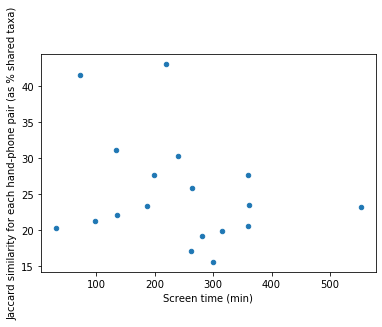

In [274]:
screentime_df.plot(x = "Screen time (min)", y = "Jaccard similarity for each hand-phone pair (as % shared taxa)", kind='scatter')

In [275]:
Rp, pp = stats.pearsonr(screentime_df["Screen time (min)"], screentime_df["Jaccard similarity for each hand-phone pair (as % shared taxa)"])
print(f'The pearson correlation coefficient is: {Rp}')
print(f'The p-value is: {pp}')

The pearson correlation coefficient is: -0.26780118530799435
The p-value is: 0.28264543289414534


In [276]:
Rs, ps = stats.spearmanr(screentime_df["Screen time (min)"], screentime_df["Jaccard similarity for each hand-phone pair (as % shared taxa)"])
print(f'The spearman correlation coefficient is: {Rs}')
print(f'The p-value is: {ps}')

The spearman correlation coefficient is: -0.23644814715262344
The p-value is: 0.3448448554112168


There doesn't appear to be a correlation.

### Using Weighted UniFrac

In [65]:
import pandas as pd

%matplotlib inline

In [187]:
tsv_file='phone_microbiome_metadata.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('phone_microbiome_metadata.csv',index=False)

In [69]:
metadata_df = pd.read_csv('phone_microbiome_metadata.csv', index_col='sample id')

Sorting the DataFrame in order of index

In [70]:
metadata_df.sort_index(inplace=True)
metadata_df.index

Index(['515rcbc272', '515rcbc273', '515rcbc274', '515rcbc275', '515rcbc276',
       '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281',
       '515rcbc282', '515rcbc284', '515rcbc285', '515rcbc286', '515rcbc287',
       '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292',
       '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc296', '515rcbc297',
       '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301', '515rcbc302',
       '515rcbc303', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307',
       '515rcbc308', '515rcbc309', '515rcbc311', '515rcbc312', '515rcbc313',
       '515rcbc314', '515rcbc315', '515rcbc316', '515rcbc317', '515rcbc318',
       '515rcbc319', '515rcbc320', '515rcbc321', '515rcbc322', '515rcbc323',
       '515rcbc324', '515rcbc325', '515rcbc326', '515rcbc327', '515rcbc328',
       '515rcbc329', '515rcbc330', '515rcbc331'],
      dtype='object', name='sample id')

The samples that had too low a number of sequences, and their corresponding hand or phone samples (for the same individual), as well as the phone or hand samples corresponding to the samples that failed quality control, were removed from the DataFrame so that only paired hand and phone samples were present.

In [71]:
metadata_df.drop(['515rcbc272', '515rcbc274', '515rcbc275', '515rcbc276', '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281', '515rcbc285', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc308', '515rcbc309', '515rcbc311', '515rcbc313', '515rcbc315', '515rcbc326'], inplace = True)

In [72]:
metadata_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
sample id,,,,,,,,,,
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly


The Weighted UniFrac distance matrix was converted to a comma separated value file so that it could be imported as a DataFrame.

In [73]:
%%time
!qiime tools export \
    --input-path alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix.qza \
    --output-path alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix

Exported alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix
CPU times: user 161 ms, sys: 50 ms, total: 211 ms
Wall time: 15.7 s


In [75]:
tsv_file='alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix/distance-matrix.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix/distance-matrix.csv',index=False)

In [76]:
unifrac_df = pd.read_csv('alpha-beta-no-chloroplast/weighted_unifrac_distance_matrix/distance-matrix.csv', index_col='sample-id')

In [77]:
unifrac_df.sort_index(inplace=True)
unifrac_df.index

Index(['515rcbc273', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc282',
       '515rcbc284', '515rcbc286', '515rcbc287', '515rcbc288', '515rcbc289',
       '515rcbc290', '515rcbc291', '515rcbc292', '515rcbc293', '515rcbc294',
       '515rcbc295', '515rcbc296', '515rcbc297', '515rcbc298', '515rcbc299',
       '515rcbc300', '515rcbc301', '515rcbc302', '515rcbc303', '515rcbc304',
       '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc312',
       '515rcbc313', '515rcbc314', '515rcbc315', '515rcbc316', '515rcbc317',
       '515rcbc318', '515rcbc319', '515rcbc320', '515rcbc321', '515rcbc322',
       '515rcbc323', '515rcbc324', '515rcbc325', '515rcbc327', '515rcbc328',
       '515rcbc329', '515rcbc330', '515rcbc331'],
      dtype='object', name='sample-id')

The samples corresponding to hand or phone samples that had too low a number of sequences or failed quality control were removed from the DataFrame so that only paired hand and phone samples were present.

In [78]:
unifrac_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc313', '515rcbc315'], inplace = True)

In [79]:
unifrac_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc296', '515rcbc302', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307', '515rcbc311', '515rcbc313', '515rcbc315'], axis = 1, inplace = True)

In [80]:
unifrac_df

,515rcbc273,515rcbc282,515rcbc289,515rcbc299,515rcbc330,515rcbc329,515rcbc300,515rcbc292,515rcbc331,515rcbc320,...,515rcbc287,515rcbc312,515rcbc291,515rcbc298,515rcbc325,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
sample-id,,,,,,,,,,,,,,,,,,,,,
515rcbc273,0.000000,0.217790,0.069525,0.154408,0.206015,0.366008,0.131793,0.136723,0.191576,0.236332,...,0.140263,0.206667,0.132049,0.139925,0.240543,0.357967,0.245198,0.151685,0.223779,0.180424
515rcbc282,0.217790,0.000000,0.204783,0.294561,0.242305,0.337169,0.279418,0.274022,0.193635,0.252139,...,0.282796,0.062498,0.283931,0.292711,0.228273,0.378935,0.191775,0.296357,0.085646,0.223685
515rcbc284,0.180424,0.223685,0.179078,0.259586,0.148894,0.348329,0.197868,0.241000,0.198188,0.165461,...,0.244046,0.202044,0.229612,0.250894,0.209929,0.291626,0.223207,0.264724,0.234447,0.000000
515rcbc286,0.255432,0.154521,0.256540,0.349982,0.230696,0.279907,0.318517,0.336578,0.251049,0.275640,...,0.339999,0.125441,0.338365,0.336148,0.261659,0.320177,0.152258,0.355066,0.161044,0.205512
515rcbc287,0.140263,0.282796,0.155234,0.053272,0.256551,0.452599,0.157081,0.046703,0.200616,0.309896,...,0.000000,0.295180,0.068239,0.049285,0.285223,0.391401,0.333225,0.061168,0.299994,0.244046
515rcbc288,0.148701,0.295680,0.165721,0.044064,0.257588,0.455689,0.166644,0.049289,0.214826,0.319994,...,0.047284,0.312555,0.089063,0.044768,0.300420,0.404512,0.347171,0.046843,0.300602,0.257382
515rcbc289,0.069525,0.204783,0.000000,0.164205,0.223877,0.380924,0.147925,0.146164,0.201415,0.236339,...,0.155234,0.192478,0.140178,0.161167,0.249049,0.369784,0.249035,0.165611,0.215087,0.179078
515rcbc290,0.151887,0.282280,0.167571,0.207964,0.237779,0.408208,0.107863,0.190771,0.227708,0.161603,...,0.186490,0.274730,0.155612,0.195229,0.267664,0.354222,0.284714,0.204431,0.298808,0.185596
515rcbc291,0.132049,0.283931,0.140178,0.077300,0.261297,0.453116,0.128555,0.074869,0.211943,0.267897,...,0.068239,0.284839,0.000000,0.081817,0.288268,0.390437,0.322843,0.087266,0.304211,0.229612


The Jaccard similarity and phone microbiome metadata DataFrames were combined.

In [81]:
combined_df = pd.concat([metadata_df, unifrac_df], axis=1, sort=False)

In [82]:
combined_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc287,515rcbc312,515rcbc291,515rcbc298,515rcbc325,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.140263,0.206667,0.132049,0.139925,0.240543,0.357967,0.245198,0.151685,0.223779,0.180424
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.282796,0.062498,0.283931,0.292711,0.228273,0.378935,0.191775,0.296357,0.085646,0.223685
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.244046,0.202044,0.229612,0.250894,0.209929,0.291626,0.223207,0.264724,0.234447,0.000000
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.339999,0.125441,0.338365,0.336148,0.261659,0.320177,0.152258,0.355066,0.161044,0.205512
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.000000,0.295180,0.068239,0.049285,0.285223,0.391401,0.333225,0.061168,0.299994,0.244046
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.047284,0.312555,0.089063,0.044768,0.300420,0.404512,0.347171,0.046843,0.300602,0.257382
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.155234,0.192478,0.140178,0.161167,0.249049,0.369784,0.249035,0.165611,0.215087,0.179078
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.186490,0.274730,0.155612,0.195229,0.267664,0.354222,0.284714,0.204431,0.298808,0.185596
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.068239,0.284839,0.000000,0.081817,0.288268,0.390437,0.322843,0.087266,0.304211,0.229612
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.046703,0.288784,0.074869,0.059575,0.282295,0.402095,0.328674,0.057610,0.293542,0.241000


The following steps were used so that the DataFrame had columns corresponding to hand samples (in addition to the metadata columns) and rows corresponding to phone samples.

In [83]:
combined_df.drop(['515rcbc273', '515rcbc282', '515rcbc284', '515rcbc286', '515rcbc287', '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292', '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc297', '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301'], axis = 1, inplace = True)

In [84]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [85]:
subset_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.200864,0.306238,0.177786,0.259394,0.244080,0.206667,0.240543,0.357967,0.245198,0.223779
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.146807,0.161792,0.241233,0.127944,0.272478,0.062498,0.228273,0.378935,0.191775,0.085646
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.239556,0.300147,0.099225,0.248781,0.172043,0.202044,0.209929,0.291626,0.223207,0.234447
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.200183,0.205387,0.225451,0.163402,0.255622,0.125441,0.261659,0.320177,0.152258,0.161044
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.275905,0.390766,0.253032,0.336297,0.299039,0.295180,0.285223,0.391401,0.333225,0.299994
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.281454,0.395116,0.266409,0.343380,0.312457,0.312555,0.300420,0.404512,0.347171,0.300602
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.222308,0.276717,0.199863,0.239422,0.262899,0.192478,0.249049,0.369784,0.249035,0.215087
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.269106,0.362105,0.180883,0.302859,0.240382,0.274730,0.267664,0.354222,0.284714,0.298808
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.258551,0.380409,0.224214,0.324854,0.271970,0.284839,0.288268,0.390437,0.322843,0.304211
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.265469,0.382056,0.248815,0.331054,0.304829,0.288784,0.282295,0.402095,0.328674,0.293542


The Jaccard similarity between each person's hand and their mobile phone, and between the same hand sample and the average similarities for all of the other phones was calculated for each pair of hand and phone samples.

In [86]:
sample2 = float(subset_df[subset_df['sample number'] == 2]['515rcbc303'])

In [87]:
sample2other = subset_df[subset_df['sample number'] != 2]['515rcbc303'].mean(axis=0)

In [88]:
sample11 = float(subset_df[subset_df['sample number'] == 11]['515rcbc312'])

In [89]:
sample11other = subset_df[subset_df['sample number'] != 11]['515rcbc312'].mean(axis=0)

In [90]:
sample13 = float(subset_df[subset_df['sample number'] == 13]['515rcbc314'])

In [91]:
sample13other = subset_df[subset_df['sample number'] != 13]['515rcbc314'].mean(axis=0)

In [92]:
sample15 = float(subset_df[subset_df['sample number'] == 15]['515rcbc316'])

In [93]:
sample15other = subset_df[subset_df['sample number'] != 15]['515rcbc316'].mean(axis=0)

In [94]:
sample16 = float(subset_df[subset_df['sample number'] == 16]['515rcbc317'])

In [95]:
sample16other = subset_df[subset_df['sample number'] != 16]['515rcbc317'].mean(axis=0)

In [96]:
sample17 = float(subset_df[subset_df['sample number'] == 17]['515rcbc318'])

In [97]:
sample17other = subset_df[subset_df['sample number'] != 17]['515rcbc318'].mean(axis=0)

In [98]:
sample18 = float(subset_df[subset_df['sample number'] == 18]['515rcbc319'])

In [99]:
sample18other = subset_df[subset_df['sample number'] != 18]['515rcbc319'].mean(axis=0)

In [100]:
sample19 = float(subset_df[subset_df['sample number'] == 19]['515rcbc320'])

In [101]:
sample19other = subset_df[subset_df['sample number'] != 19]['515rcbc320'].mean(axis=0)

In [102]:
sample20 = float(subset_df[subset_df['sample number'] == 20]['515rcbc321'])

In [103]:
sample20other = subset_df[subset_df['sample number'] != 20]['515rcbc321'].mean(axis=0)

In [104]:
sample21 = float(subset_df[subset_df['sample number'] == 21]['515rcbc322'])

In [105]:
sample21other = subset_df[subset_df['sample number'] != 21]['515rcbc322'].mean(axis=0)

In [106]:
sample22 = float(subset_df[subset_df['sample number'] == 22]['515rcbc323'])

In [107]:
sample22other = subset_df[subset_df['sample number'] != 22]['515rcbc323'].mean(axis=0)

In [108]:
sample23 = float(subset_df[subset_df['sample number'] == 23]['515rcbc324'])

In [109]:
sample23other = subset_df[subset_df['sample number'] != 23]['515rcbc324'].mean(axis=0)

In [110]:
sample24 = float(subset_df[subset_df['sample number'] == 24]['515rcbc325'])

In [111]:
sample24other = subset_df[subset_df['sample number'] != 24]['515rcbc325'].mean(axis=0)

In [112]:
sample26 = float(subset_df[subset_df['sample number'] == 26]['515rcbc327'])

In [113]:
sample26other = subset_df[subset_df['sample number'] != 26]['515rcbc327'].mean(axis=0)

In [114]:
sample27 = float(subset_df[subset_df['sample number'] == 27]['515rcbc328'])

In [115]:
sample27other = subset_df[subset_df['sample number'] != 27]['515rcbc328'].mean(axis=0)

In [116]:
sample28 = float(subset_df[subset_df['sample number'] == 28]['515rcbc329'])

In [117]:
sample28other = subset_df[subset_df['sample number'] != 28]['515rcbc329'].mean(axis=0)

In [118]:
sample29 = float(subset_df[subset_df['sample number'] == 29]['515rcbc330'])

In [119]:
sample29other = subset_df[subset_df['sample number'] != 29]['515rcbc330'].mean(axis=0)

In [120]:
sample30 = float(subset_df[subset_df['sample number'] == 30]['515rcbc331'])

In [121]:
sample30other = subset_df[subset_df['sample number'] != 30]['515rcbc331'].mean(axis=0)

A Pandas DataFrame containing a summary of the Jaccard similarities between each person's hand and their phone and between the same hand sample and the average similarities of the other phones was compiled, with the rows labelled with each sample number.

In [122]:
dict = {"weighted unifrac individual": [sample2, sample11, sample13, sample15, sample16, sample17, sample18, sample19, sample20, sample21, sample22, sample23, sample24, sample26, sample27, sample28, sample29, sample30], "weighted unifrac other": [sample2other, sample11other, sample13other, sample15other, sample16other, sample17other, sample18other, sample19other, sample20other, sample21other, sample22other, sample23other, sample24other, sample26other, sample27other, sample28other, sample29other, sample30other]}

In [123]:
weighted_unifrac_summary = pd.DataFrame(dict)

In [124]:
weighted_unifrac_summary.index = ["sample 2", "sample 11", "sample 13", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [125]:
weighted_unifrac_summary

,weighted unifrac individual,weighted unifrac other
sample 2,0.245198,0.293646
sample 11,0.062498,0.264738
sample 13,0.099225,0.229111
sample 15,0.078838,0.311544
sample 16,0.336297,0.287778
sample 17,0.378514,0.327537
sample 18,0.276717,0.344884
sample 19,0.161603,0.277452
sample 20,0.288596,0.250057
sample 21,0.293542,0.262183


The mean value was calculated for each column.

In [246]:
weighted_unifrac_summary["weighted unifrac individual"].mean()

0.2620882902984173

In [247]:
weighted_unifrac_summary["weighted unifrac other"].mean()

0.28682338492014164

In [248]:
import numpy as np
from scipy import stats

In [249]:
weighted_unifrac_summary[["weighted unifrac individual", "weighted unifrac other"]].describe()

,weighted unifrac individual,weighted unifrac other
count,18.000000,18.000000
mean,0.262088,0.286823
std,0.106803,0.051739
min,0.086952,0.205405
25%,0.219857,0.251043
50%,0.254972,0.275554
75%,0.311610,0.308673
max,0.467007,0.408829


A paired t-test was carried out to find out if the differences in the means for the Jaccard similarities for each pair of hand and phone samples differed from the average Jaccard similarity between each hand sample and all of the other phone samples.

In [250]:
R, p = stats.ttest_rel(weighted_unifrac_summary["weighted unifrac individual"], weighted_unifrac_summary["weighted unifrac other"])
print(f'The t-statistic is: {R}')
print(f'The p-value is: {p}')

The t-statistic is: -1.2168778557897404
The p-value is: 0.240275344682101


P > 0.05, so this is statistically significant.

#### For females only

The same method was used on a DataFrame filtered to contain only female samples.

In [129]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [130]:
subset_df_f = subset_df[subset_df['gender or gender of owner'] == 'female']

In [131]:
subset_df_f

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.239556,0.300147,0.099225,0.248781,0.172043,0.202044,0.209929,0.291626,0.223207,0.234447
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.275905,0.390766,0.253032,0.336297,0.299039,0.295180,0.285223,0.391401,0.333225,0.299994
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.281454,0.395116,0.266409,0.343380,0.312457,0.312555,0.300420,0.404512,0.347171,0.300602
515rcbc294,P23,phone,23,female,NaN,female,32,32.0,never,never,...,0.276570,0.389305,0.259111,0.336008,0.301772,0.299411,0.305210,0.392775,0.346074,0.293130
515rcbc298,P27,phone,27,female,NaN,female,263,263.0,monthly,monthly,...,0.283566,0.385679,0.255886,0.337585,0.298388,0.303953,0.300267,0.382143,0.336108,0.298397
515rcbc300,P29,phone,29,female,NaN,female,241,241.0,monthly,monthly,...,0.258656,0.332137,0.177918,0.267674,0.225948,0.273559,0.257459,0.365642,0.269963,0.292234
515rcbc301,P30,phone,30,female,NaN,female,361,361.0,yearly,yearly,...,0.286931,0.392226,0.268501,0.344544,0.309492,0.314500,0.313370,0.395119,0.351939,0.306098


In [150]:
sample13_f = float(subset_df_f[subset_df_f['sample number'] == 13]['515rcbc314'])

In [151]:
sample16_f = float(subset_df_f[subset_df_f['sample number'] == 16]['515rcbc317'])

In [152]:
sample17_f = float(subset_df_f[subset_df_f['sample number'] == 17]['515rcbc318'])

In [153]:
sample23_f = float(subset_df_f[subset_df_f['sample number'] == 23]['515rcbc324'])

In [154]:
sample27_f = float(subset_df_f[subset_df_f['sample number'] == 27]['515rcbc328'])

In [155]:
sample29_f = float(subset_df_f[subset_df_f['sample number'] == 29]['515rcbc330'])

In [156]:
sample30_f = float(subset_df_f[subset_df_f['sample number'] == 30]['515rcbc331'])

In [157]:
dict_f = {"weighted unifrac females": [sample13_f, sample16_f, sample17_f, sample23_f, sample27_f, sample29_f, sample30_f]}

In [158]:
weighted_unifrac_summary_f = pd.DataFrame(dict_f)

In [159]:
weighted_unifrac_summary_f.index = ["sample 13", "sample 16", "sample 17", "sample 23", "sample 27", "sample 29", "sample 30"]

In [160]:
weighted_unifrac_summary_f

,weighted unifrac females
sample 13,0.099225
sample 16,0.336297
sample 17,0.378514
sample 23,0.392775
sample 27,0.298388
sample 29,0.230801
sample 30,0.223186


In [161]:
weighted_unifrac_summary_f["weighted unifrac females"].mean()

0.27988359222365383

In [165]:
weighted_unifrac_summary_f[["weighted unifrac females"]].describe()

,weighted unifrac females
count,7.000000
mean,0.279884
std,0.103488
min,0.099225
25%,0.226993
50%,0.298388
75%,0.357405
max,0.392775


#### For males only

The same method was used on a DataFrame filtered to contain only male samples.

In [166]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [167]:
subset_df_m = subset_df[subset_df['gender or gender of owner'] == 'male']

In [168]:
subset_df_m

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc327,515rcbc319,515rcbc314,515rcbc317,515rcbc328,515rcbc312,515rcbc325,515rcbc324,515rcbc303,515rcbc322
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.200864,0.306238,0.177786,0.259394,0.244080,0.206667,0.240543,0.357967,0.245198,0.223779
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.146807,0.161792,0.241233,0.127944,0.272478,0.062498,0.228273,0.378935,0.191775,0.085646
515rcbc286,P15,phone,15,male,NaN,male,73,73.0,monthly,monthly,...,0.200183,0.205387,0.225451,0.163402,0.255622,0.125441,0.261659,0.320177,0.152258,0.161044
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.222308,0.276717,0.199863,0.239422,0.262899,0.192478,0.249049,0.369784,0.249035,0.215087
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.269106,0.362105,0.180883,0.302859,0.240382,0.274730,0.267664,0.354222,0.284714,0.298808
515rcbc291,P20,phone,20,male,NaN,male,360,360.0,weekly,weekly,...,0.258551,0.380409,0.224214,0.324854,0.271970,0.284839,0.288268,0.390437,0.322843,0.304211
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.265469,0.382056,0.248815,0.331054,0.304829,0.288784,0.282295,0.402095,0.328674,0.293542
515rcbc293,P22,phone,22,male,NaN,male,264,264.0,monthly,monthly,...,0.246648,0.331622,0.172993,0.281128,0.229462,0.246603,0.242511,0.329443,0.262835,0.263783
515rcbc295,P24,phone,24,male,NaN,male,99,99.0,never,never,...,0.276240,0.392224,0.256646,0.334212,0.300393,0.302273,0.294868,0.387672,0.336613,0.301076
515rcbc297,P26,phone,26,male,NaN,male,315,315.0,weekly,weekly,...,0.253137,0.361055,0.216353,0.303399,0.263594,0.267796,0.265786,0.376042,0.300466,0.277270


In [169]:
sample2_m = float(subset_df_m[subset_df_m['sample number'] == 2]['515rcbc303'])

In [171]:
sample11_m = float(subset_df_m[subset_df_m['sample number'] == 11]['515rcbc312'])

In [172]:
sample15_m = float(subset_df_m[subset_df_m['sample number'] == 15]['515rcbc316'])

In [173]:
sample18_m = float(subset_df_m[subset_df_m['sample number'] == 18]['515rcbc319'])

In [174]:
sample19_m = float(subset_df_m[subset_df_m['sample number'] == 19]['515rcbc320'])

In [175]:
sample20_m = float(subset_df_m[subset_df_m['sample number'] == 20]['515rcbc321'])

In [176]:
sample21_m = float(subset_df_m[subset_df_m['sample number'] == 21]['515rcbc322'])

In [177]:
sample22_m = float(subset_df_m[subset_df_m['sample number'] == 22]['515rcbc323'])

In [178]:
sample24_m = float(subset_df_m[subset_df_m['sample number'] == 24]['515rcbc325'])

In [179]:
sample26_m = float(subset_df_m[subset_df_m['sample number'] == 26]['515rcbc327'])

In [180]:
sample28_m = float(subset_df_m[subset_df_m['sample number'] == 28]['515rcbc329'])

In [181]:
dict_m = {"weighted unifrac males": [sample2_m, sample11_m, sample15_m, sample18_m, sample19_m, sample20_m, sample21_m, sample22_m, sample24_m, sample26_m, sample28_m]}

In [182]:
weighted_unifrac_summary_m = pd.DataFrame(dict_m)

In [183]:
weighted_unifrac_summary_m.index = ["sample 2", "sample 11", "sample 15", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 24", "sample 26", "sample 28"]

In [184]:
weighted_unifrac_summary_m

,weighted unifrac males
sample 2,0.245198
sample 11,0.062498
sample 15,0.078838
sample 18,0.276717
sample 19,0.161603
sample 20,0.288596
sample 21,0.293542
sample 22,0.213616
sample 24,0.294868
sample 26,0.253137


In [185]:
weighted_unifrac_summary_m["weighted unifrac males"].mean()

0.23888840880387055

In [187]:
weighted_unifrac_summary_m[["weighted unifrac males"]].describe()

,weighted unifrac males
count,11.000000
mean,0.238888
std,0.110511
min,0.062498
25%,0.187609
50%,0.253137
75%,0.291069
max,0.459159


In [192]:
Rm, pm = stats.ttest_ind(weighted_unifrac_summary_f["weighted unifrac females"], weighted_unifrac_summary_m["weighted unifrac males"], equal_var=False)
print(f'The t-statistic is: {Rm}')
print(f'The p-value is {pm}')

The t-statistic is: 0.7978365225969419
The p-value is 0.4386970346996931


P > 0.05, so the means are not significantly different when considering male samples only.

#### Does phone microbiome resemblance correlate with screen time?

In [202]:
subset_df_hand = metadata_df[metadata_df['sample origin'] == 'hand']

In [203]:
subset_df_hand.index = ["sample 2", "sample 11", "sample 13", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [204]:
screentime_df = pd.concat([weighted_unifrac_summary["weighted unifrac individual"], subset_df_hand["screen time min"]], axis=1, sort=False)

In [205]:
screentime_df.sort_values(by="screen time min", ascending=True)

,weighted unifrac individual,screen time min
sample 23,0.392775,32
sample 15,0.078838,73
sample 24,0.294868,99
sample 13,0.099225,135
sample 18,0.276717,136
sample 21,0.293542,188
sample 19,0.161603,199
sample 11,0.062498,220
sample 29,0.230801,241
sample 27,0.298388,263


In [206]:
screentime_df.columns = ["Weighted UniFrac for each hand-phone pair", "Screen time (min)"]

In [207]:
screentime_df

,Weighted UniFrac for each hand-phone pair,Screen time (min)
sample 2,0.245198,360
sample 11,0.062498,220
sample 13,0.099225,135
sample 15,0.078838,73
sample 16,0.336297,552
sample 17,0.378514,300
sample 18,0.276717,136
sample 19,0.161603,199
sample 20,0.288596,360
sample 21,0.293542,188


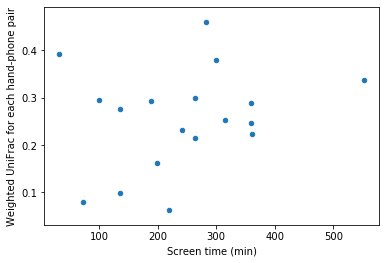

In [199]:
screentime_df.plot(x = "Screen time (min)", y = "Weighted UniFrac for each hand-phone pair", kind='scatter')

In [200]:
Rp, pp = stats.pearsonr(screentime_df["Screen time (min)"], screentime_df["Weighted UniFrac for each hand-phone pair"])
print(f'The pearson correlation coefficient is: {Rp}')
print(f'The p-value is: {pp}')

The pearson correlation coefficient is: 0.2409534339836073
The p-value is: 0.33545644426434995


In [201]:
Rs, ps = stats.spearmanr(screentime_df["Screen time (min)"], screentime_df["Weighted UniFrac for each hand-phone pair"])
print(f'The spearman correlation coefficient is: {Rs}')
print(f'The p-value is: {ps}')

The spearman correlation coefficient is: 0.1652039456088199
The p-value is: 0.5123985603835295


There doesn't appear to be a correlation.